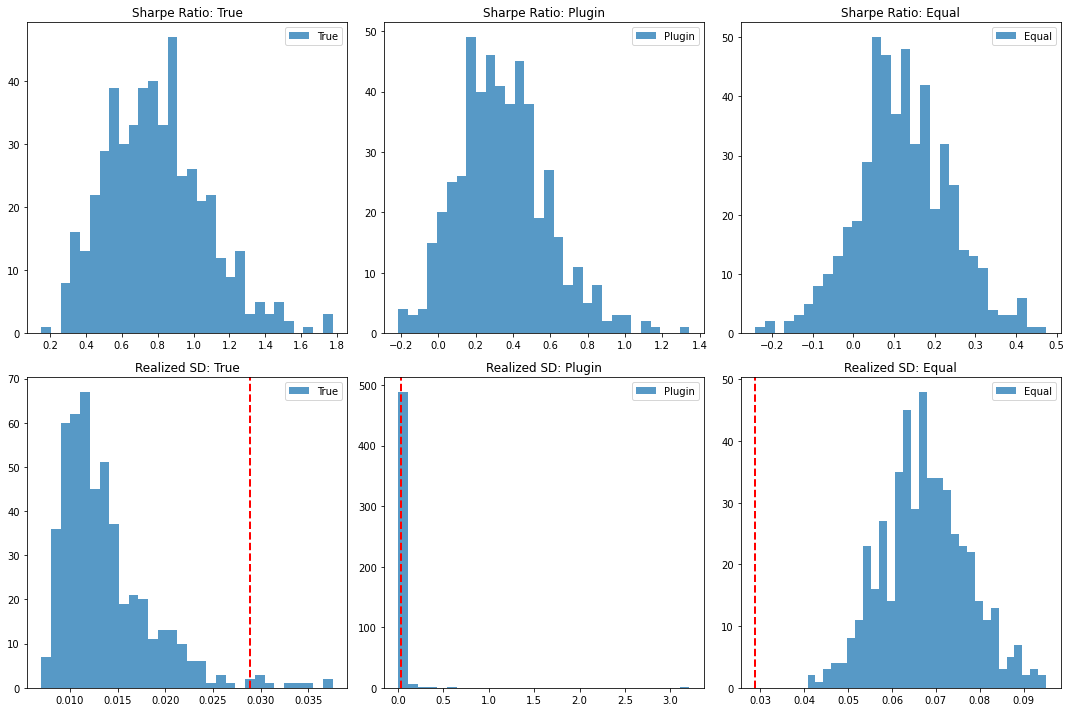

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Test for multiple assets, N. 
N = 25
T = 120
T1 = 40
num_simulations = 500
target_sd = 0.10 / np.sqrt(12)

def simulate_returns(N, T, mu_range, sigma_range):
    mu = np.random.uniform(mu_range[0], mu_range[1], N)
    sigma = np.random.uniform(sigma_range[0], sigma_range[1], N)
    D = np.diag(sigma)
    C = np.full((N, N), 0.5)
    np.fill_diagonal(C, 1)
    Sigma = D @ C @ D
    return np.random.multivariate_normal(mu, Sigma, T), mu, Sigma

sharpe_ratios = {'True': [], 'Plugin': [], 'Equal': []}
realized_sds = {'True': [], 'Plugin': [], 'Equal': []}

for _ in range(num_simulations):
    returns, mu, Sigma = simulate_returns(N, T, (0.05/12, 0.15/12), (0.05/np.sqrt(12), 0.60/np.sqrt(12)))
    returns_df = pd.DataFrame(returns)

    # True Tangency Portfolio
    true_weights = np.linalg.inv(Sigma) @ mu / (np.ones(N).T @ np.linalg.inv(Sigma) @ mu)
    true_returns = returns_df @ true_weights
    true_sd = np.sqrt(true_weights.T @ Sigma @ true_weights)
    true_sharpe = np.mean(true_returns[T1:]) / np.std(true_returns[T1:])
    sharpe_ratios['True'].append(true_sharpe)
    realized_sds['True'].append(true_sd)

    # Plugin Estimator Portfolio
    historical_returns = returns_df.iloc[:T1]
    mu_hat = historical_returns.mean()
    Sigma_hat = historical_returns.cov()
    plugin_weights = np.linalg.inv(Sigma_hat) @ mu_hat / (np.ones(N).T @ np.linalg.inv(Sigma_hat) @ mu_hat)
    plugin_returns = returns_df.iloc[T1:] @ plugin_weights
    plugin_sd = np.sqrt(plugin_weights.T @ Sigma_hat @ plugin_weights)
    plugin_sharpe = np.mean(plugin_returns) / np.std(plugin_returns)
    sharpe_ratios['Plugin'].append(plugin_sharpe)
    realized_sds['Plugin'].append(plugin_sd)

    # Equally-Weighted Portfolio
    equal_weights = np.ones(N) / N
    equal_returns = returns_df.iloc[T1:] @ equal_weights
    equal_sd = np.sqrt(equal_weights.T @ Sigma_hat @ equal_weights)
    equal_sharpe = np.mean(equal_returns) / np.std(equal_returns)
    sharpe_ratios['Equal'].append(equal_sharpe)
    realized_sds['Equal'].append(equal_sd)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Sharpe 
for i, strategy in enumerate(sharpe_ratios):
    axs[0, i].hist(sharpe_ratios[strategy], bins=30, alpha=0.75, label=strategy)
    axs[0, i].set_title(f'Sharpe Ratio: {strategy}')
    axs[0, i].legend()

# Realized Standard Deviations
for i, strategy in enumerate(realized_sds):
    axs[1, i].hist(realized_sds[strategy], bins=30, alpha=0.75, label=strategy)
    axs[1, i].axvline(target_sd, color='r', linestyle='dashed', linewidth=2)
    axs[1, i].set_title(f'Realized SD: {strategy}')
    axs[1, i].legend()

plt.tight_layout()
plt.show()